## <a id='table of contents'>Содержание</a>  
<a href='#part1'>1. ПОСТАНОВКА ЗАДАЧИ</a>     
<a href='#part2'>2. ЗАГРУЗКА И ОПИСАНИЕ ДАННЫХ</a>    
<a href='#part3'>3. ПРЕДОБРАБОТКА ДАННЫХ</a>      
<a href='#part4'>4. ОБУЧЕНИЕ МОДЕЛЕЙ</a>      
<a href='#part5'>5 ВЫВОДЫ И ВОПРОСЫ </a>

# <a id='part1'>1. ПОСТАНОВКА ЗАДАЧИ</a>
<a href='#table of contents'>к оглавлению</a>

***Цель:*** Обучить модель классификации, которая будет выявлять токсичные комментарии.   
***Целевая метрика:*** - F1, значение должно быть не меньше 0,75

# <a id='part2'> 2. ЗАГРУЗКА И ОПИСАНИЕ ДАННЫХ</a>
<a href='#table of contents'>к оглавлению</a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
pd.options.mode.chained_assignment = None
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
try:
    df=pd.read_csv('toxic_comments.csv')
except:
    df=pd.read_csv('/datasets/toxic_comments.csv')

In [ ]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hjhkljhgfd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
display(df)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Проверим баланс классов

0    0.898321
1    0.101679
Name: toxic, dtype: float64


Text(0.5, 0, 'Класс')

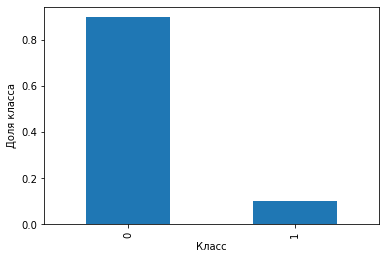

In [ ]:
class_frequency=df['toxic'].value_counts(normalize=2/len(df))
print(class_frequency)
class_frequency.plot(kind='bar')
plt.ylabel("Доля класса")
plt.xlabel("Класс")

***Вывод 1***  
* Пропуски в данных отсутствуют.
* Существует дисбаланс классов.

# <a id='part3'>3. ПРЕДОБРАБОТКА ДАННЫХ </a>
<a href='#table of contents'>к оглавлению</a>

Загрузим библиотеку WordNet

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hjhkljhgfd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hjhkljhgfd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Создадим корпус с твитами

In [ ]:
corpus=df['text'].str.lower()

Создадим функцию для подготовки текста к векторизации

In [ ]:
def preparate_to_education(text):
    lemmer=WordNetLemmatizer()
    words=nltk.word_tokenize(text)   #разобъем твиты на слова
    words_lemmatize=' '.join([lemmer.lemmatize(word) for word in words])  #лемматизируем слова и соединим в предложения
    text_eng=re.sub(r'[^a-zA-Z ]', ' ', words_lemmatize)   #удалим лишние знаки
    text_split=" ".join(text_eng.split())   #удалим лишние пробелы и соединим слова через пробелы
    return text_split

Подготовим твиты

In [ ]:
corpus_lemmatize=corpus.apply(preparate_to_education)

Добавим лемматизированный столбец в датафрейм

In [ ]:
df['text_prepare']=corpus_lemmatize

In [ ]:
display(df)

,text,toxic,text_prepare
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n t make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


# <a id='part4'>4. ОБУЧЕНИЕ МОДЕЛЕЙ </a>
<a href='#table of contents'>к оглавлению</a>

Разделим данные на тренировочную, валидационную и тестовую выборки

In [ ]:
features=df['text_prepare'].values
target=df['toxic'].values

Разделим данные на тренировочную, валидационную и тестовую выборки

In [ ]:
#получим тренировочную и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=12345)

#получим валидационную выборку

features_train, features_valid, target_train, target_valid = train_test_split(
features_train, target_train, test_size=0.3, random_state=12345)

Рассчитаем TFIDF для всех выборок

In [ ]:
stop_words_eng=stopwords.words('english')
count_tf_idf=TfidfVectorizer(stop_words=stop_words_eng) #если убрать стоп-слова, то никак не получается метрика выше 0,748.

In [ ]:
tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_valid = count_tf_idf.transform(features_valid)
tf_idf_test = count_tf_idf.transform(features_test)

In [ ]:
print(tf_idf_train.shape)
print(tf_idf_test.shape)
print(tf_idf_valid.shape)

(83774, 110998)
(39893, 110998)
(35904, 110998)


Создадим функцию для обучения моделей

In [ ]:
def learning_model (data_features_train, data_target_train,  #функция принимает данные и модель
                    data_features_valid, data_target_valid,
                    data_features_test, data_target_test,
                    model):

    model.fit(data_features_train, data_target_train)     #обучим модель
    predictions_valid=model.predict(data_features_valid) #сделаем предсказания на валидационной выборке
    predicted_test=model.predict(data_features_test)     #сделаем предсказания на тестовой выборке

    result__valid=f1_score(data_target_valid, predictions_valid) #посчитаем метрику на валидационной выборке
    result__test=f1_score(data_target_test, predicted_test) #посчитаем метрику на тестовой выборке

    print('F1_score на валидационной выборке: ', result__valid)
    print('F1_score на тестовой выборке: ', result__test)


    return result__valid, result__test

***ОБУЧИМ МОДЕЛЬ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ***

***L1 регуляризация***

In [ ]:
for C in np.arange (0.1, 2.8, 0.1):
    model_LogisticRegression_L1=LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear', C=C)
    learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test,
                   model_LogisticRegression_L1)

F1_score на валидационной выборке:  0.7210649574756565
F1_score на тестовой выборке:  0.7174344280361473
F1_score на валидационной выборке:  0.7265980368685658
F1_score на тестовой выборке:  0.7239982949701619
F1_score на валидационной выборке:  0.7299287410926365
F1_score на тестовой выборке:  0.7304769945124524
F1_score на валидационной выборке:  0.7310655446248666
F1_score на тестовой выборке:  0.7304019309476335
F1_score на валидационной выборке:  0.7357685009487666
F1_score на тестовой выборке:  0.7340737636211232
F1_score на валидационной выборке:  0.7365795724465558
F1_score на тестовой выборке:  0.7353713625380818
F1_score на валидационной выборке:  0.7401049117787315
F1_score на тестовой выборке:  0.7376169944263329
F1_score на валидационной выборке:  0.7426241304869272
F1_score на тестовой выборке:  0.740403933594163
F1_score на валидационной выборке:  0.7435712569093968
F1_score на тестовой выборке:  0.7419183889772124
F1_score на валидационной выборке:  0.7437876960193003
F

C:\Users\hjhkljhgfd\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1_score на валидационной выборке:  0.7515970515970516
F1_score на тестовой выборке:  0.7529923830250272
F1_score на валидационной выборке:  0.7524044389642416
F1_score на тестовой выборке:  0.7541448516579407
F1_score на валидационной выборке:  0.7532210109018832
F1_score на тестовой выборке:  0.7553319479383135
F1_score на валидационной выборке:  0.752856433184302
F1_score на тестовой выборке:  0.757266644729626
F1_score на валидационной выборке:  0.753547423450336
F1_score на тестовой выборке:  0.7582792386401144
F1_score на валидационной выборке:  0.7547122706278867
F1_score на тестовой выборке:  0.75774616826552
F1_score на валидационной выборке:  0.7561342013019529
F1_score на тестовой выборке:  0.7579949098152042
F1_score на валидационной выборке:  0.7569671102184283
F1_score на тестовой выборке:  0.7589038056141129
F1_score на валидационной выборке:  0.7575719492270956
F1_score на тестовой выборке:  0.758367619259424
F1_score на валидационной выборке:  0.7570834907442388
F1_sco

***L2 регуляризация***

In [ ]:
model_LogisticRegression_L1=LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear')
learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_LogisticRegression_L1)

F1_score на валидационной выборке:  0.7428362394829898
F1_score на тестовой выборке:  0.745846817691478


(0.7428362394829898, 0.745846817691478)

In [ ]:
model_LogisticRegression_L1=LogisticRegression(class_weight='balanced', penalty='l2', solver='newton-cg')
learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_LogisticRegression_L1)

F1_score на валидационной выборке:  0.7428362394829898
F1_score на тестовой выборке:  0.746007768666379


(0.7428362394829898, 0.746007768666379)

In [ ]:
model_LogisticRegression_L1=LogisticRegression(class_weight='balanced', penalty='l2', solver='lbfgs', max_iter=800)
learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_LogisticRegression_L1)

F1_score на валидационной выборке:  0.7428362394829898
F1_score на тестовой выборке:  0.746007768666379


(0.7428362394829898, 0.746007768666379)

***Вывод 1:*** Добить логистическую регрсессию до 0.75 не получается. Хотя мы близки)

Применим градиентный спуск

In [ ]:
model_SGDClassifier=SGDClassifier(class_weight='balanced', loss="squared_hinge", penalty="l2",
                                  max_iter=4000, random_state=12345)
learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_SGDClassifier)

F1_score на валидационной выборке:  0.6956284153005464
F1_score на тестовой выборке:  0.7041535098372602


C:\Users\hjhkljhgfd\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


(0.6956284153005464, 0.7041535098372602)

***ОБУЧИМ ДЕРЕВЯННЫЕ МОДЕЛИ***

ОБУЧИМ МОДЕЛЬ ДЕРЕВА РЕШЕНИЙ

In [ ]:
for depth in range(50, 100, 10):
    model_DecisionTreeClassifier = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_DecisionTreeClassifier)

F1_score на валидационной выборке:  0.6400892110398663
F1_score на тестовой выборке:  0.6434456928838951
F1_score на валидационной выборке:  0.6136160429173585
F1_score на тестовой выборке:  0.6082322258759496
F1_score на валидационной выборке:  0.6251450676982592
F1_score на тестовой выборке:  0.612947658402204
F1_score на валидационной выборке:  0.6243426959086829
F1_score на тестовой выборке:  0.623163648787154
F1_score на валидационной выборке:  0.6304069618633222
F1_score на тестовой выборке:  0.6294427883512955


ОБУЧИМ МОДЕЛЬ СЛУЧАЙНОГО ЛЕСА

Попробуем разные виды балансировки

In [ ]:
model_RandomForestClassifier=RandomForestClassifier(class_weight='balanced', random_state=123, max_depth=100)
learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_RandomForestClassifier)

F1_score на валидационной выборке:  0.5684016582220176
F1_score на тестовой выборке:  0.5583290881304126


(0.5684016582220176, 0.5583290881304126)

In [ ]:
model_RandomForestClassifier=RandomForestClassifier(class_weight='balanced_subsample', random_state=123)
learning_model(tf_idf_train, target_train, tf_idf_valid, target_valid, tf_idf_test, target_test, model_RandomForestClassifier)

F1_score на валидационной выборке:  0.6251149108291966
F1_score на тестовой выборке:  0.640698238241474


(0.6251149108291966, 0.640698238241474)

***ОБУЧИМ МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА***

#создадим словарь с перебираемыми параметрами
parametrs = { 'n_estimators': range (2, 20, 2),
              'max_depth': range (10, 100, 10)}

model=LGBMClassifier(random_state=42, class_weight='balanced',
                     learning_rate=0.5, verbose=10)
grid=GridSearchCV(model, parametrs, scoring='f1', cv=3)
model_fit=grid.fit(tf_idf_train, target_train)
best_score=grid.best_score_
print("Лучшее f1_score на тренировочных данных:", abs(best_score))
print("Лучшие параметры:", grid.best_params_)

# <a id='part5'>5. ВЫВОДЫ И ВОПРОСЫ </a>
<a href='#table of contents'>к оглавлению</a>

***Выводы***

* Получить метрику выше 0,75 у меня получилось только на логистической регрессии, а все остальные модели дают результат хуже.
* Снижение количества данных (если убрать стоп слова) приводит к ухудшение метрики
* На моем ноуте я не смог даже загрузить библиотеку с Бертом, про обучение соотвественно речь вообще не идет)